In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import scatter_matrix
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.signal import argrelextrema
import warnings
warnings.filterwarnings("ignore")

C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\David\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# read raw data
data = pd.read_csv("household_power_consumption.txt",
                  sep=';',
                  index_col=False)

In [3]:
# create time series from data
cols = data.columns.drop(['Date', 'Time'])
data[cols] = data[cols].apply(pd.to_numeric,
                              errors='coerce')
data['Date'] = pd.to_datetime(data['Date'],
                             format='%d/%m/%Y')
data['Time'] = pd.to_datetime(data['Time'],
                             format='%H:%M:%S').dt.time


In [4]:
# function to extract seconds for simpler point of reference
def time_convert(x):
    h = x.hour
    m = x.minute
    s = x.second
    return (h*60+m)*60+s


In [5]:
## apply function and create new column
data['Seconds'] = data['Time'].apply(time_convert)

In [6]:
# fill in missing data
data = data.fillna(0)

In [7]:
# get day of week for dates where 0-Monday to 6-Sunday
data['Weekday'] = data['Date'].dt.dayofweek

In [8]:
# resulting dataset
data

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds,Weekday
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,62640,5
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,62700,5
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,62760,5
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,62820,5
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,62880,5
...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,75480,4
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,75540,4
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,75600,4
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,75660,4


In [9]:
# get only Fridays
friday_data = data.loc[data['Weekday'] == 4]

In [10]:
# Fridays data
friday_data

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds,Weekday
7596,2006-12-22,00:00:00,0.206,0.000,245.70,0.8,0.0,0.0,0.0,0,4
7597,2006-12-22,00:01:00,0.206,0.000,246.18,0.8,0.0,0.0,0.0,60,4
7598,2006-12-22,00:02:00,0.328,0.130,245.61,1.4,0.0,0.0,0.0,120,4
7599,2006-12-22,00:03:00,0.314,0.128,244.63,1.4,0.0,0.0,0.0,180,4
7600,2006-12-22,00:04:00,0.310,0.128,244.51,1.4,0.0,0.0,0.0,240,4
...,...,...,...,...,...,...,...,...,...,...,...
2075254,2010-11-26,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,75480,4
2075255,2010-11-26,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,75540,4
2075256,2010-11-26,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,75600,4
2075257,2010-11-26,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0,75660,4


In [11]:
sns.set_theme(style='darkgrid')

In [12]:
sns.set(rc={'figure.figsize':(24,10)})

In [13]:
# get Friday Dec 22 2006
friday_dec_22 = friday_data.loc[friday_data['Date']=='2006-12-22']

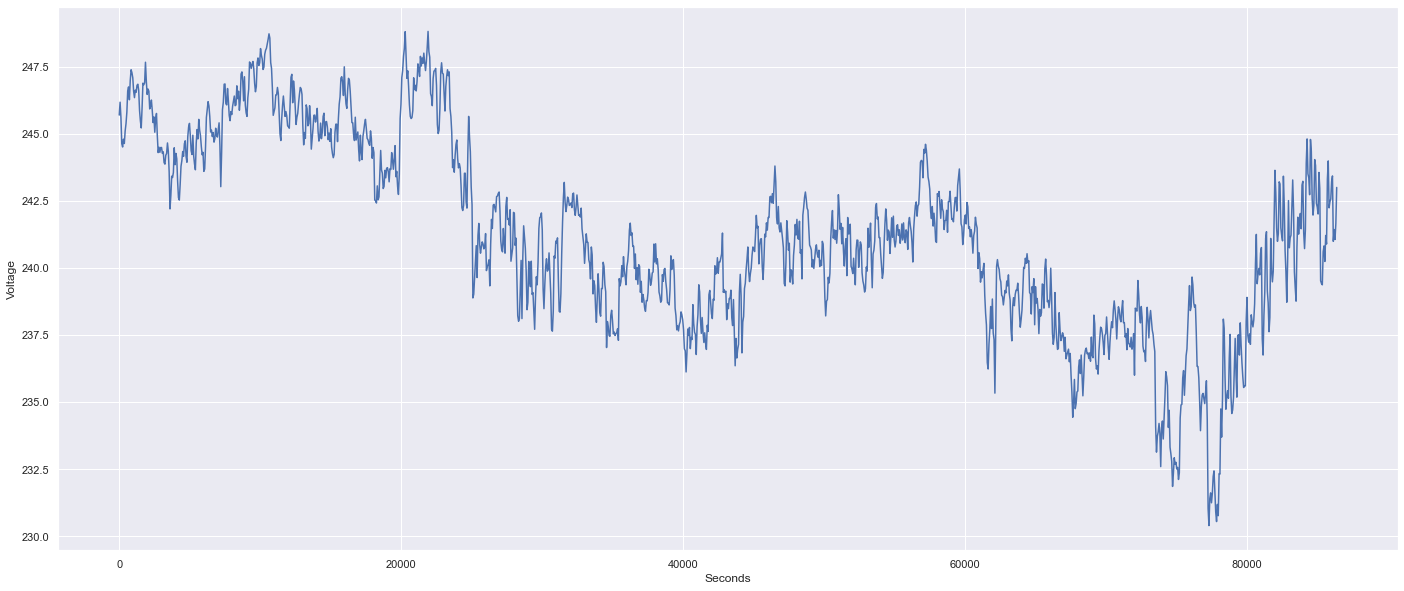

In [14]:
# some plots of variables through time
sns.lineplot(data=friday_dec_22,
            x='Seconds',
            y='Voltage');

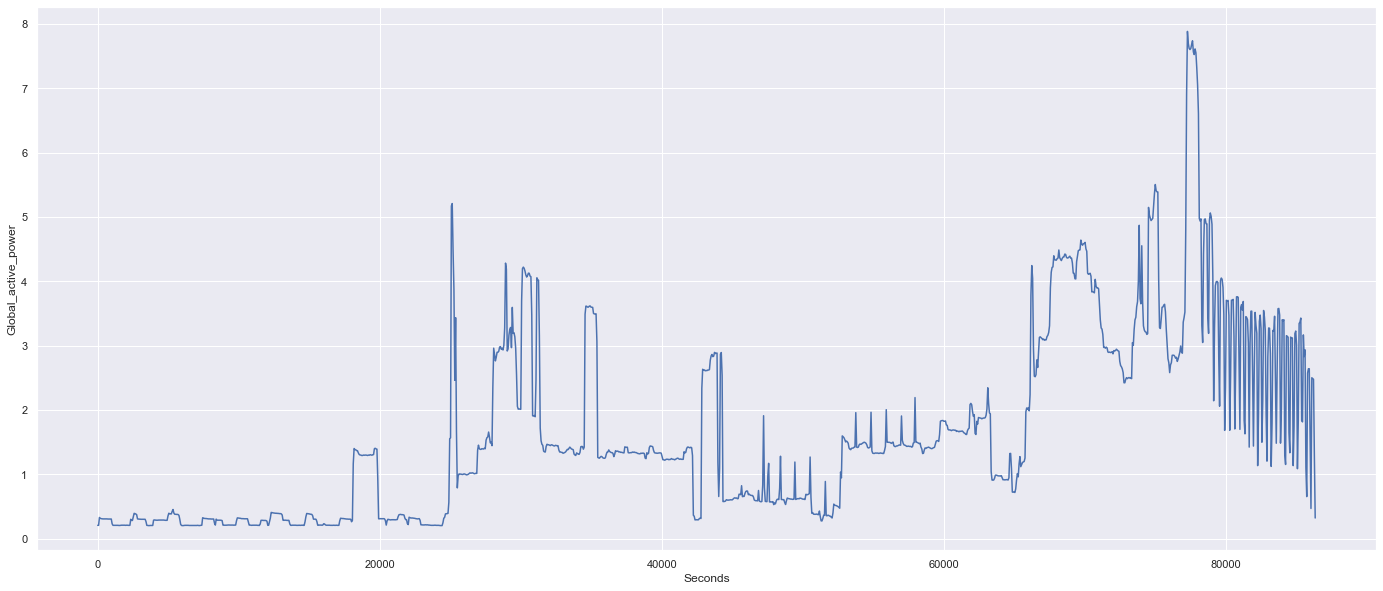

In [15]:
sns.lineplot(data=friday_dec_22,
            x='Seconds',
            y='Global_active_power');

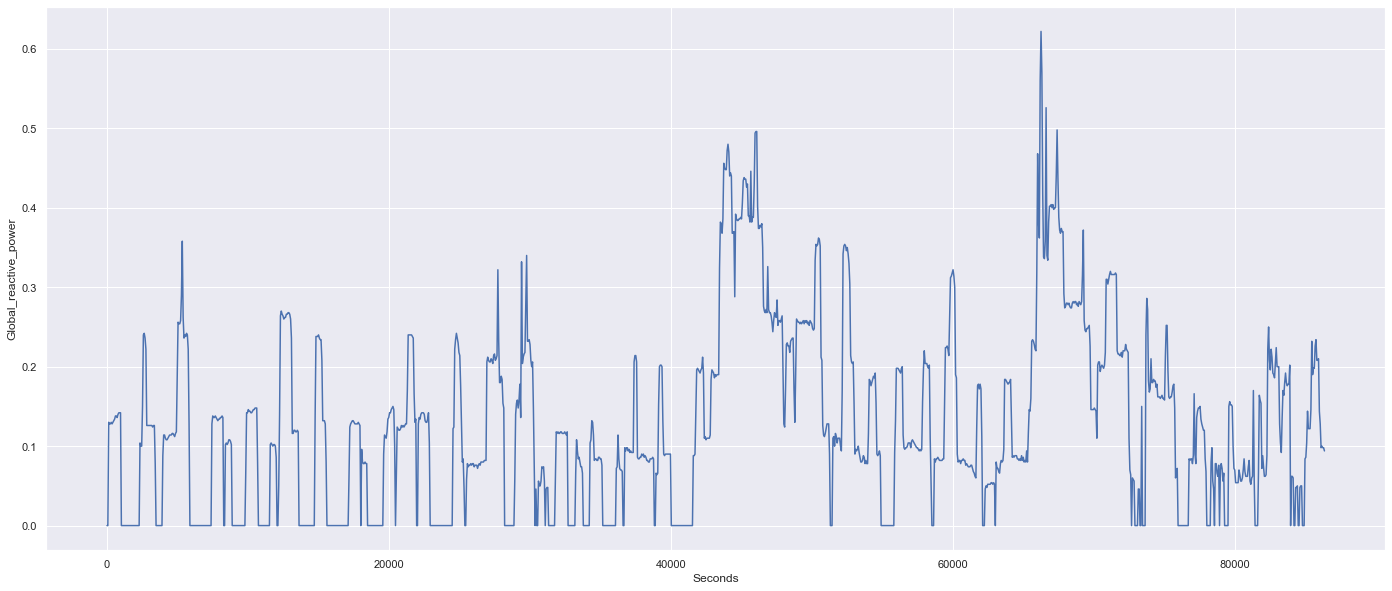

In [16]:
sns.lineplot(data=friday_dec_22,
            x='Seconds',
            y='Global_reactive_power');

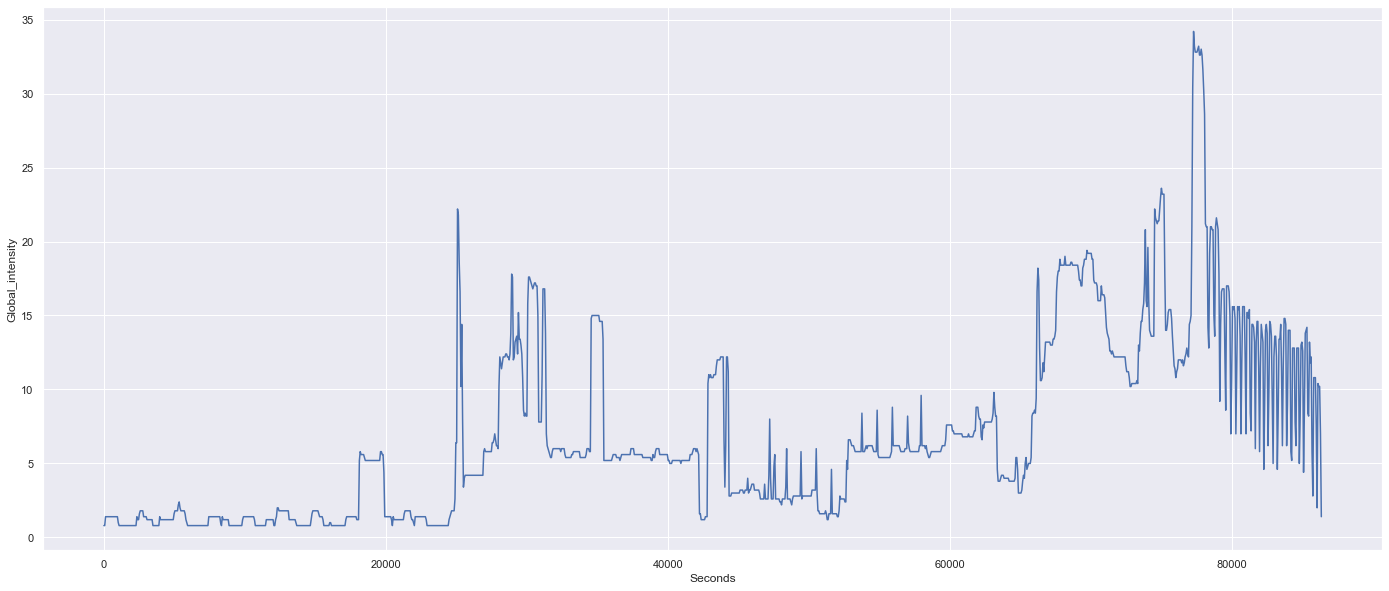

In [17]:
sns.lineplot(data=friday_dec_22,
            x='Seconds',
            y='Global_intensity');

<Figure size 1440x720 with 0 Axes>

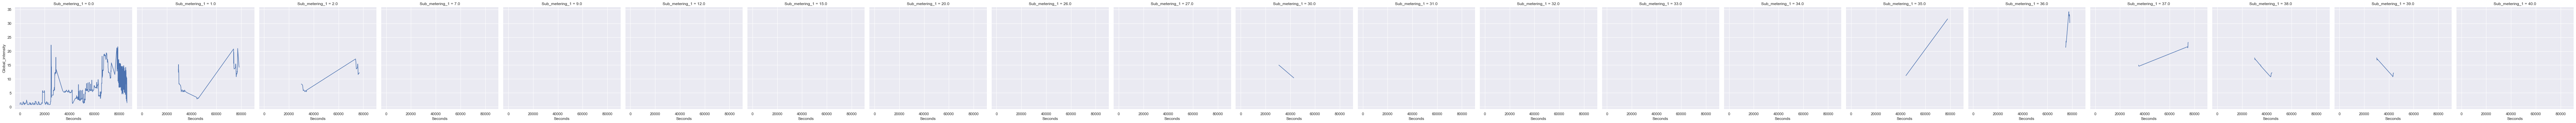

In [18]:
# explore relationships
plt.figure(figsize=(20,10))
sns.relplot(data=friday_dec_22,
           x='Seconds',
           y='Global_intensity',
           col='Sub_metering_1',
           kind='line');

<Figure size 1440x720 with 0 Axes>

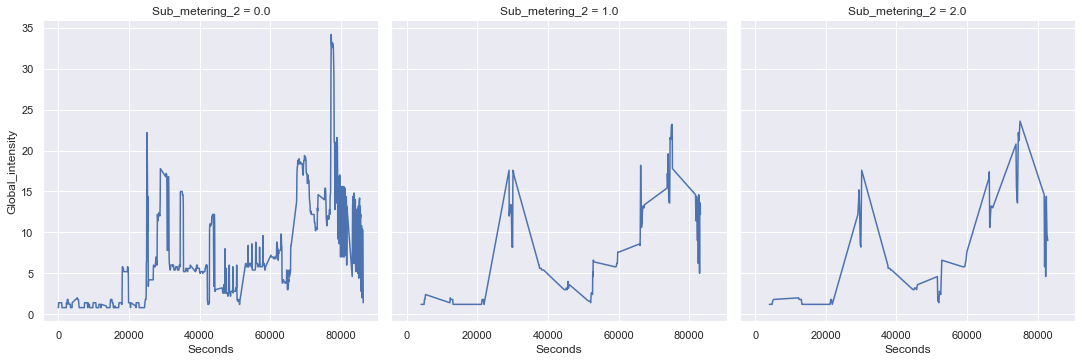

In [19]:
plt.figure(figsize=(20,10))
sns.relplot(data=friday_dec_22,
           x='Seconds',
           y='Global_intensity',
           col='Sub_metering_2',
           kind='line');

<Figure size 1440x720 with 0 Axes>

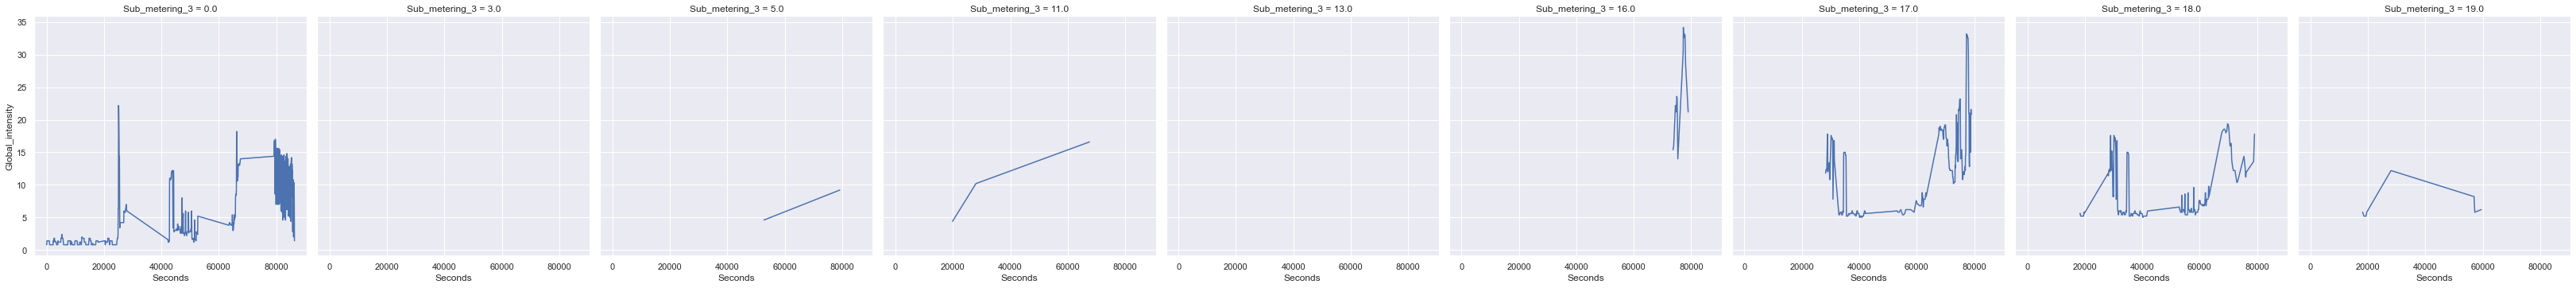

In [20]:
plt.figure(figsize=(20,10))
sns.relplot(data=friday_dec_22,
           x='Seconds',
           y='Global_intensity',
           col='Sub_metering_3',
           kind='line');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


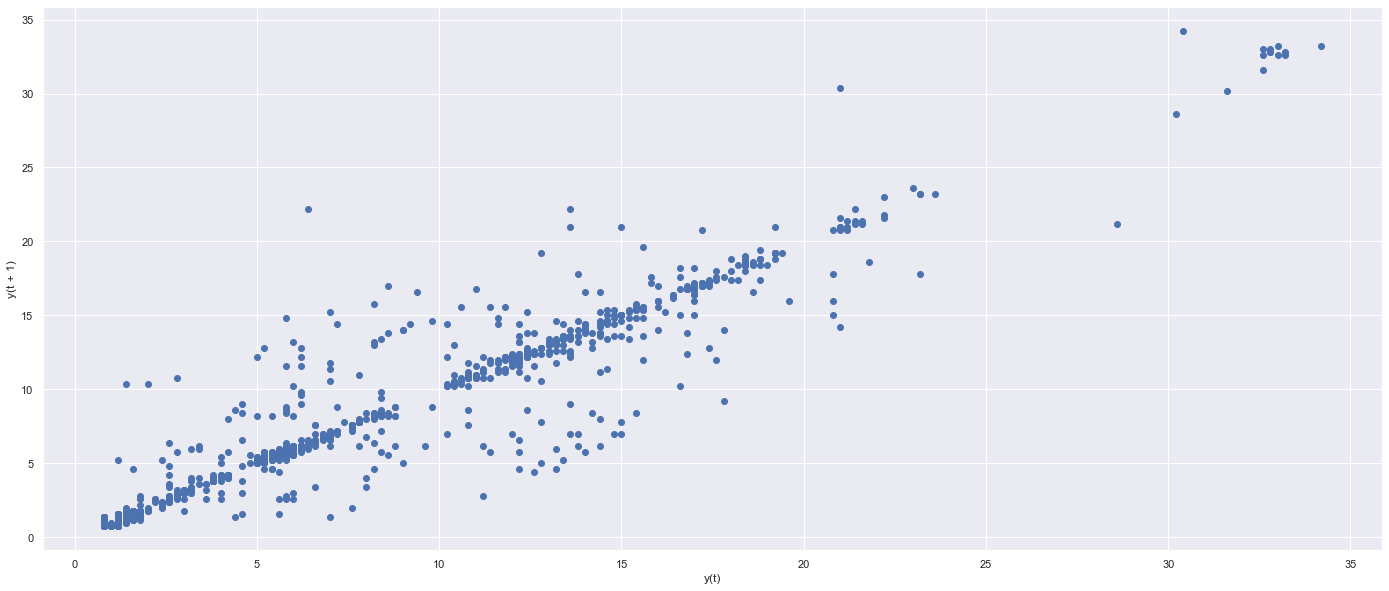

In [21]:
# lage plot of global intensity
lag_plot(friday_dec_22['Global_intensity']);

<Figure size 1728x720 with 0 Axes>

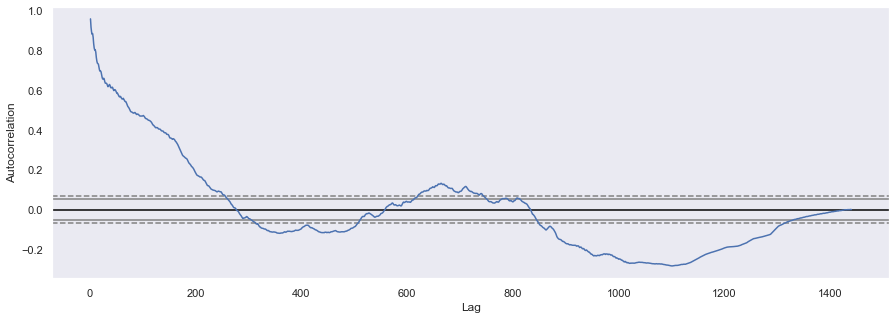

In [22]:
# getting autocorrelation graph
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
autocorrelation_plot(friday_dec_22['Global_intensity'], ax=ax);

<Figure size 1728x720 with 0 Axes>

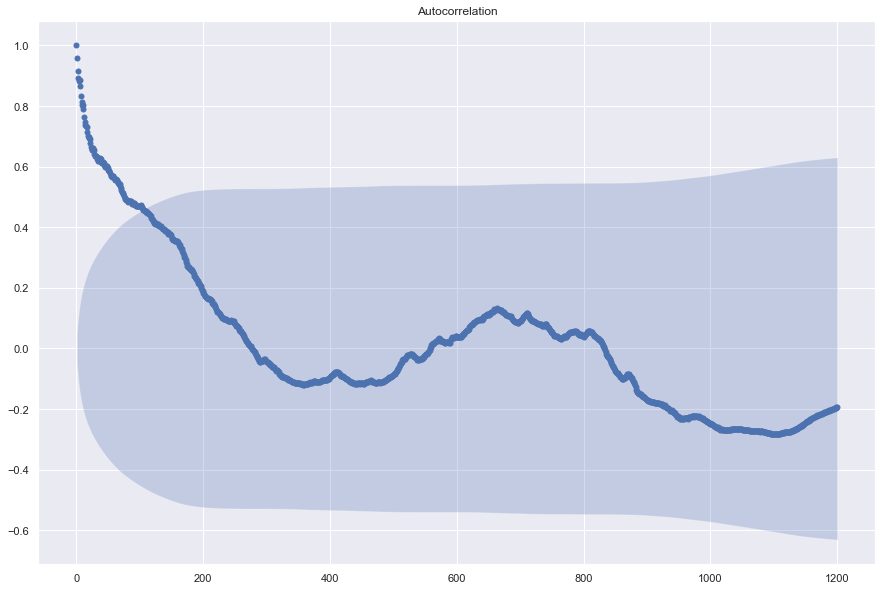

In [23]:
# evaluating autocorrelations
plt.clf()
fig, ax = plt.subplots(figsize=(15, 10))
plot_acf(friday_dec_22['Global_intensity'], lags=1200, use_vlines=False, ax=ax);

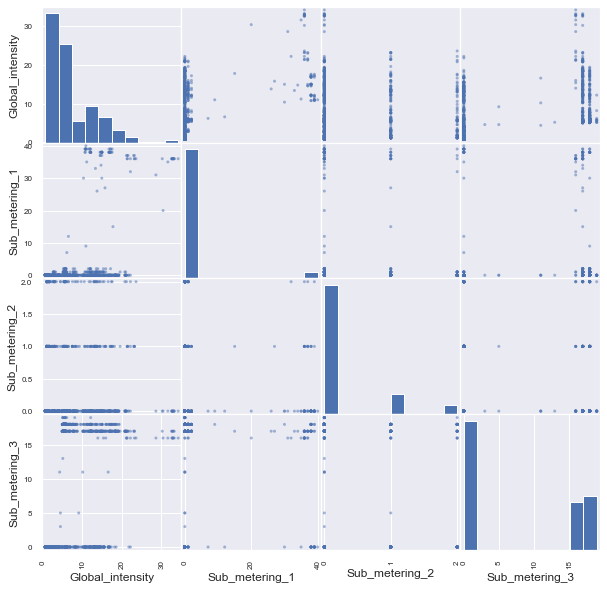

In [24]:
# some correlation scatterplot matrices
subset = friday_dec_22[['Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']]
scatter_matrix(subset, figsize=(10,10), diagonal='hist');

In [25]:
friday_dec_22_16to22 = friday_dec_22.loc[(friday_dec_22['Seconds'] >= 57600) & (friday_dec_22['Seconds'] <= 79200)]

In [26]:
friday_dec_22_16to22

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds,Weekday
8556,2006-12-22,16:00:00,1.432,0.094,241.84,5.8,0.0,0.0,18.0,57600,4
8557,2006-12-22,16:01:00,1.434,0.096,242.29,5.8,0.0,0.0,18.0,57660,4
8558,2006-12-22,16:02:00,1.422,0.094,241.56,5.8,0.0,0.0,18.0,57720,4
8559,2006-12-22,16:03:00,1.428,0.096,242.04,5.8,0.0,0.0,18.0,57780,4
8560,2006-12-22,16:04:00,1.486,0.156,241.64,6.2,0.0,0.0,18.0,57840,4
...,...,...,...,...,...,...,...,...,...,...,...
8912,2006-12-22,21:56:00,5.010,0.070,234.70,21.2,0.0,0.0,16.0,78960,4
8913,2006-12-22,21:57:00,4.886,0.078,235.14,20.8,0.0,0.0,17.0,79020,4
8914,2006-12-22,21:58:00,4.082,0.072,236.22,17.8,0.0,0.0,18.0,79080,4
8915,2006-12-22,21:59:00,2.142,0.056,237.37,9.2,0.0,0.0,5.0,79140,4


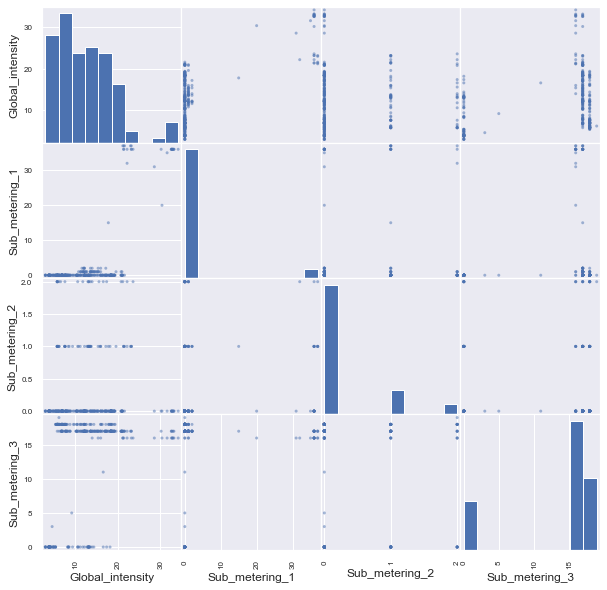

In [27]:
subset = friday_dec_22_16to22[['Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']]
scatter_matrix(subset, figsize=(10,10), diagonal='hist');

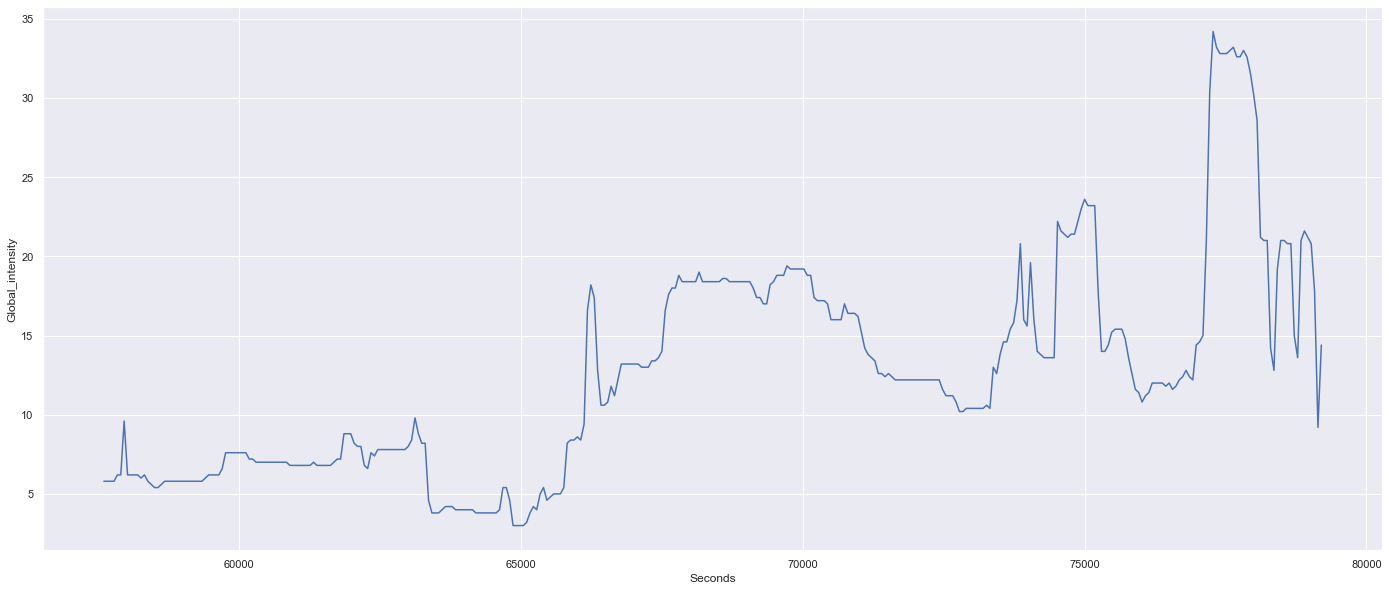

In [28]:
sns.lineplot(data=friday_dec_22_16to22,
            x='Seconds',
            y='Global_intensity');

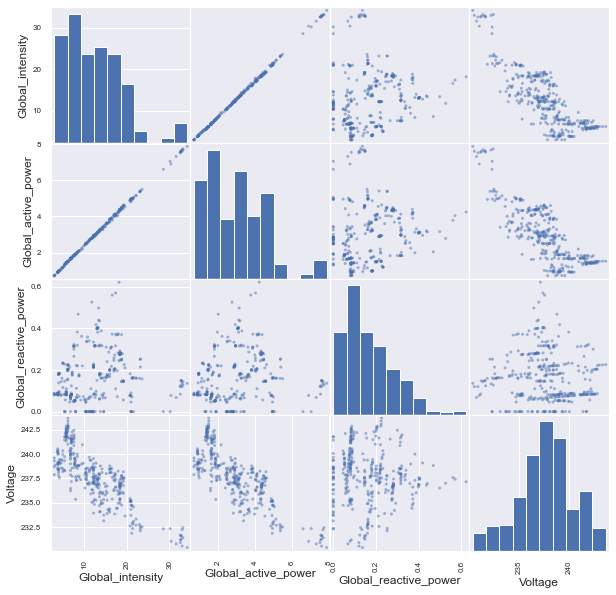

In [29]:
subset = friday_dec_22_16to22[['Global_intensity','Global_active_power','Global_reactive_power','Voltage']]
scatter_matrix(subset, figsize=(10,10), diagonal='hist');

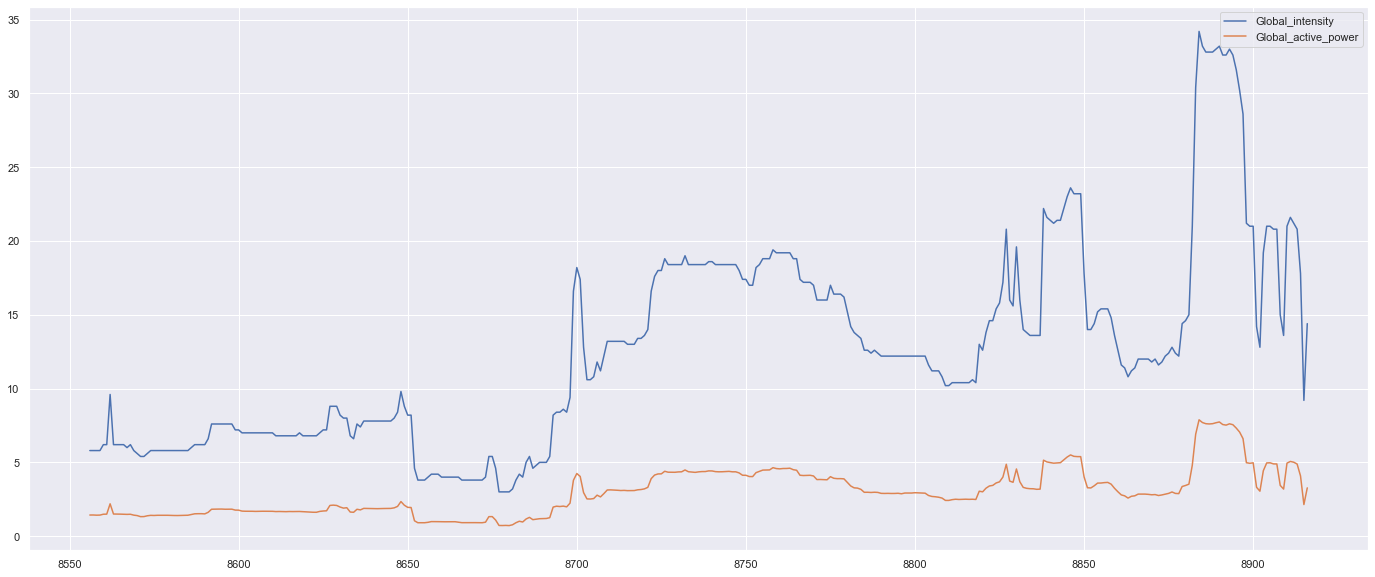

In [30]:
# some plots to find rleationship amongst global intensity vs other variables
friday_dec_22_16to22[['Global_intensity','Global_active_power']].plot();

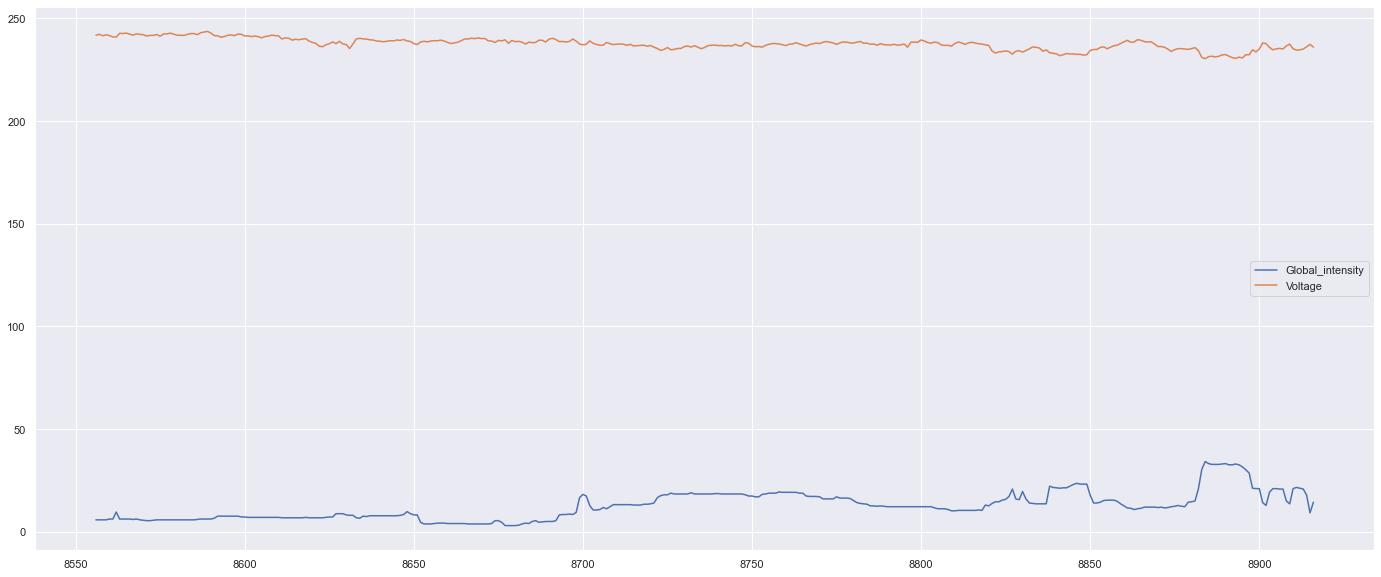

In [31]:
friday_dec_22_16to22[['Global_intensity','Voltage']].plot();

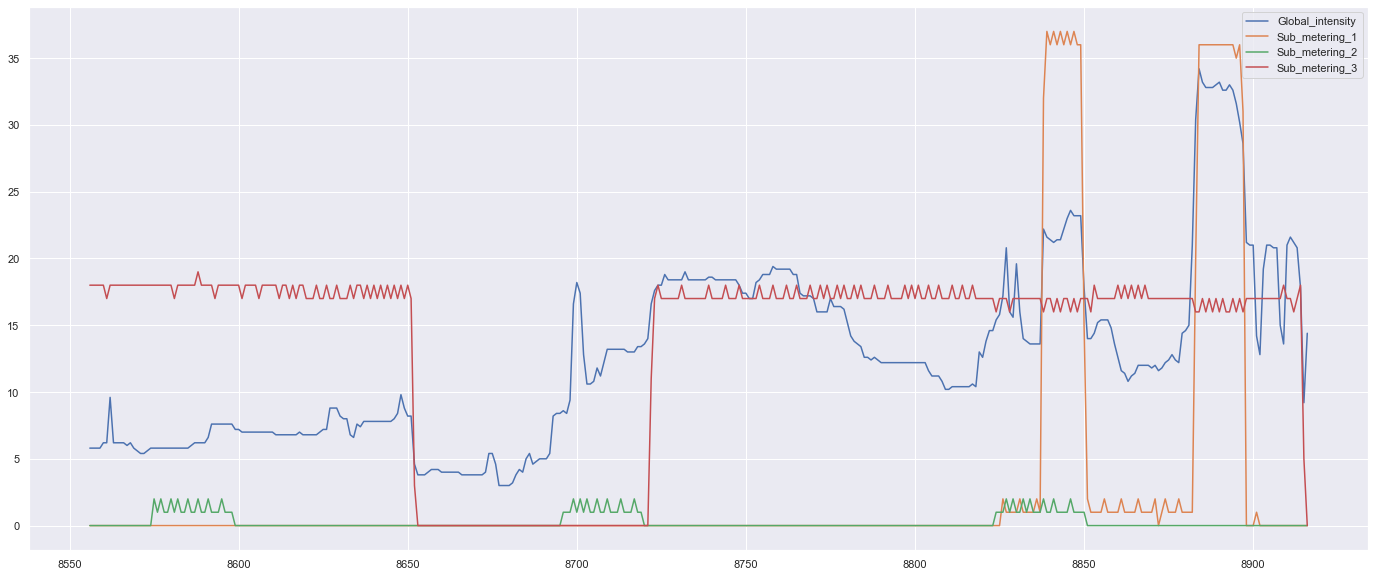

In [32]:
friday_dec_22_16to22[['Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3']].plot();

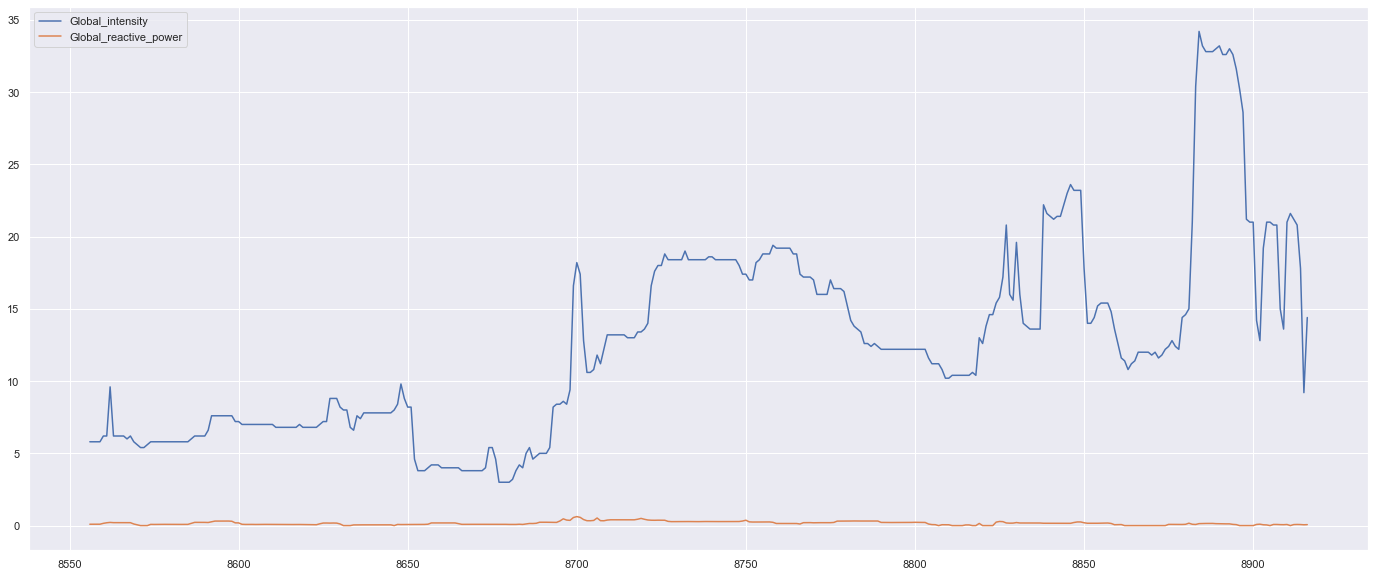

In [33]:
friday_dec_22_16to22[['Global_intensity','Global_reactive_power']].plot();

In [34]:
# preprocessing for finding seasonal trends
trend_dict = {}
tdi = pd.DatetimeIndex(friday_dec_22_16to22.Date)
friday_dec_22_16to22.set_index(tdi, inplace=True)
friday_dec_22_16to22.drop(columns='Date', inplace=True)
friday_dec_22_16to22.index.name = 'datetimeindex'

In [35]:
friday_dec_22_16to22.drop(columns=['Time'], inplace=True)

In [36]:
tdi = pd.DatetimeIndex(friday_dec_22_16to22.Seconds)
friday_dec_22_16to22.set_index(tdi, inplace=True)
friday_dec_22_16to22.drop(columns='Seconds', inplace=True)
friday_dec_22_16to22.index.name = 'datetimeindex'

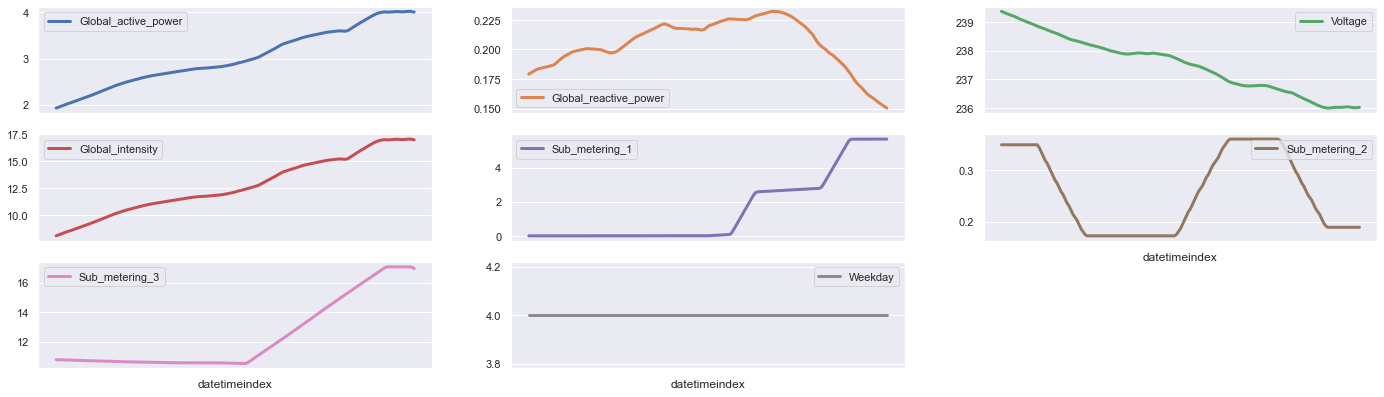

In [37]:
# seasonal trend plots
for ts in friday_dec_22_16to22.columns:
    
    decomposition = sm.tsa.seasonal_decompose(friday_dec_22_16to22[ts].dropna(),
                                             period=180)
    # Store back the results
    trend_dict[ts] = decomposition.trend

pd.DataFrame(trend_dict).plot(subplots=True, layout=(4, 3), linewidth=3);

In [38]:
df_friday_dec_22_16to22 = friday_dec_22.loc[(friday_dec_22['Seconds'] >= 57600) & (friday_dec_22['Seconds'] <= 79200)]

In [39]:
friday_dec_22

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds,Weekday
7596,2006-12-22,00:00:00,0.206,0.000,245.70,0.8,0.0,0.0,0.0,0,4
7597,2006-12-22,00:01:00,0.206,0.000,246.18,0.8,0.0,0.0,0.0,60,4
7598,2006-12-22,00:02:00,0.328,0.130,245.61,1.4,0.0,0.0,0.0,120,4
7599,2006-12-22,00:03:00,0.314,0.128,244.63,1.4,0.0,0.0,0.0,180,4
7600,2006-12-22,00:04:00,0.310,0.128,244.51,1.4,0.0,0.0,0.0,240,4
...,...,...,...,...,...,...,...,...,...,...,...
9031,2006-12-22,23:55:00,2.500,0.098,240.99,10.4,0.0,0.0,0.0,86100,4
9032,2006-12-22,23:56:00,2.488,0.100,241.43,10.2,0.0,0.0,0.0,86160,4
9033,2006-12-22,23:57:00,2.476,0.098,241.06,10.2,0.0,0.0,0.0,86220,4
9034,2006-12-22,23:58:00,1.310,0.098,241.66,7.0,0.0,0.0,0.0,86280,4


In [40]:
df_friday_dec_22_16to22

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds,Weekday
8556,2006-12-22,16:00:00,1.432,0.094,241.84,5.8,0.0,0.0,18.0,57600,4
8557,2006-12-22,16:01:00,1.434,0.096,242.29,5.8,0.0,0.0,18.0,57660,4
8558,2006-12-22,16:02:00,1.422,0.094,241.56,5.8,0.0,0.0,18.0,57720,4
8559,2006-12-22,16:03:00,1.428,0.096,242.04,5.8,0.0,0.0,18.0,57780,4
8560,2006-12-22,16:04:00,1.486,0.156,241.64,6.2,0.0,0.0,18.0,57840,4
...,...,...,...,...,...,...,...,...,...,...,...
8912,2006-12-22,21:56:00,5.010,0.070,234.70,21.2,0.0,0.0,16.0,78960,4
8913,2006-12-22,21:57:00,4.886,0.078,235.14,20.8,0.0,0.0,17.0,79020,4
8914,2006-12-22,21:58:00,4.082,0.072,236.22,17.8,0.0,0.0,18.0,79080,4
8915,2006-12-22,21:59:00,2.142,0.056,237.37,9.2,0.0,0.0,5.0,79140,4


In [41]:
# dropping variables not necessary for model
friday_dec_22.drop(columns=['Date','Time','Voltage','Weekday'],
                  inplace=True)

In [42]:
friday_dec_22

,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds
7596,0.206,0.000,0.8,0.0,0.0,0.0,0
7597,0.206,0.000,0.8,0.0,0.0,0.0,60
7598,0.328,0.130,1.4,0.0,0.0,0.0,120
7599,0.314,0.128,1.4,0.0,0.0,0.0,180
7600,0.310,0.128,1.4,0.0,0.0,0.0,240
...,...,...,...,...,...,...,...
9031,2.500,0.098,10.4,0.0,0.0,0.0,86100
9032,2.488,0.100,10.2,0.0,0.0,0.0,86160
9033,2.476,0.098,10.2,0.0,0.0,0.0,86220
9034,1.310,0.098,7.0,0.0,0.0,0.0,86280


In [43]:
df_friday_dec_22 = friday_dec_22

In [44]:
# normalizing
scaler = MinMaxScaler()

In [45]:
data_scaled = scaler.fit_transform(df_friday_dec_22.iloc[:,0:6])

In [46]:
# creating dataset for scaled data
df_friday_dec_22_scaled = df_friday_dec_22

In [47]:
# replacing scaled data
df_friday_dec_22_scaled = df_friday_dec_22_scaled.assign(Global_active_power=data_scaled[:,0])
df_friday_dec_22_scaled = df_friday_dec_22_scaled.assign(Global_reactive_power=data_scaled[:,1])
df_friday_dec_22_scaled = df_friday_dec_22_scaled.assign(Global_intensity=data_scaled[:,2])
df_friday_dec_22_scaled = df_friday_dec_22_scaled.assign(Sub_metering_1=data_scaled[:,3])
df_friday_dec_22_scaled = df_friday_dec_22_scaled.assign(Sub_metering_2=data_scaled[:,4])
df_friday_dec_22_scaled = df_friday_dec_22_scaled.assign(Sub_metering_3=data_scaled[:,5])

In [48]:
df_friday_dec_22_scaled

,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds
7596,0.000521,0.000000,0.000000,0.0,0.0,0.0,0
7597,0.000521,0.000000,0.000000,0.0,0.0,0.0,60
7598,0.016402,0.209003,0.017964,0.0,0.0,0.0,120
7599,0.014580,0.205788,0.017964,0.0,0.0,0.0,180
7600,0.014059,0.205788,0.017964,0.0,0.0,0.0,240
...,...,...,...,...,...,...,...
9031,0.299141,0.157556,0.287425,0.0,0.0,0.0,86100
9032,0.297579,0.160772,0.281437,0.0,0.0,0.0,86160
9033,0.296017,0.157556,0.281437,0.0,0.0,0.0,86220
9034,0.144233,0.157556,0.185629,0.0,0.0,0.0,86280


In [49]:
df_friday_dec_22_scaled.describe()

,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.00000
mean,0.185359,0.208675,0.181824,0.054705,0.121528,0.406835,43170.00000
std,0.186954,0.183450,0.182061,0.211638,0.273617,0.457508,24950.19038
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.020828,0.077170,0.023952,0.000000,0.000000,0.000000,21585.00000
50%,0.147097,0.176849,0.143713,0.000000,0.000000,0.000000,43170.00000
75%,0.313265,0.321543,0.300898,0.000000,0.000000,0.894737,64755.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,86340.00000


In [50]:
df_friday_dec_22.describe()

,Global_active_power,Global_reactive_power,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.00000
mean,1.625929,0.129796,6.872917,2.188194,0.243056,7.729861,43170.00000
std,1.436180,0.114106,6.080840,8.465521,0.547234,8.692648,24950.19038
min,0.202000,0.000000,0.800000,0.000000,0.000000,0.000000,0.00000
25%,0.362000,0.048000,1.600000,0.000000,0.000000,0.000000,21585.00000
50%,1.332000,0.110000,5.600000,0.000000,0.000000,0.000000,43170.00000
75%,2.608500,0.200000,10.850000,0.000000,0.000000,17.000000,64755.00000
max,7.884000,0.622000,34.200000,40.000000,2.000000,19.000000,86340.00000


In [51]:
# getting variables and target
X = df_friday_dec_22_scaled.drop(columns=['Global_intensity'])
y = df_friday_dec_22_scaled[['Global_intensity']]

In [52]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.25,
                                                   random_state=42)

<AxesSubplot:>

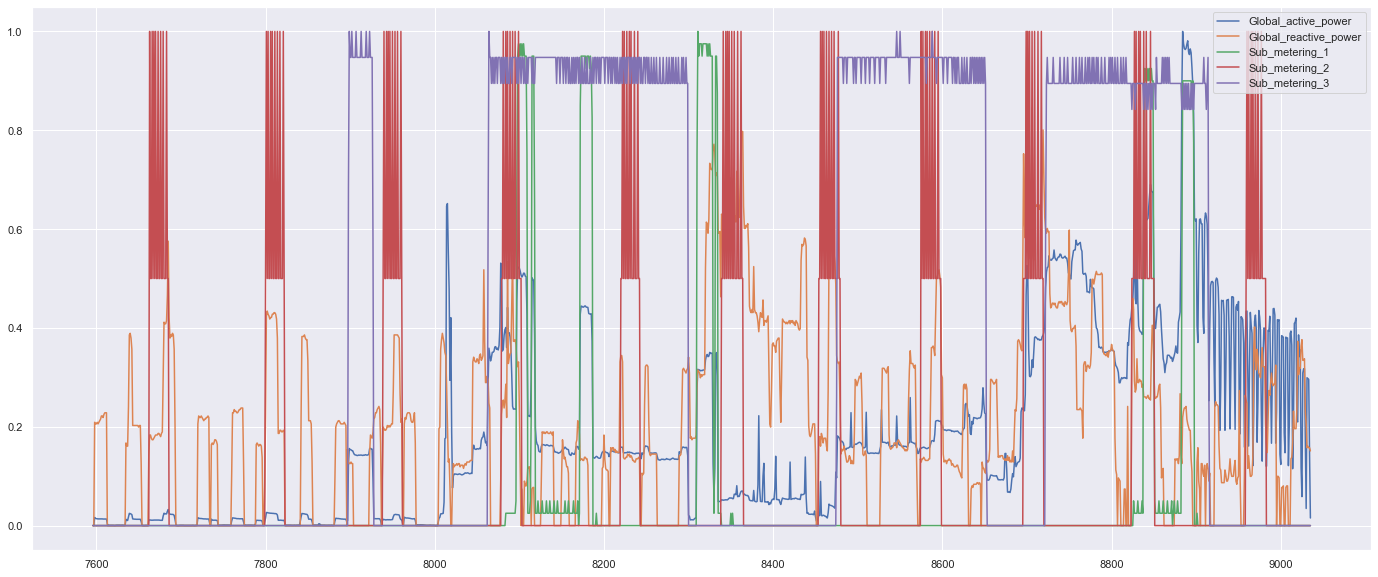

In [53]:
# plotting indicators to find relationships
exclude = ['Seconds']
X.loc[:, X.columns.difference(exclude)].plot()

<AxesSubplot:>

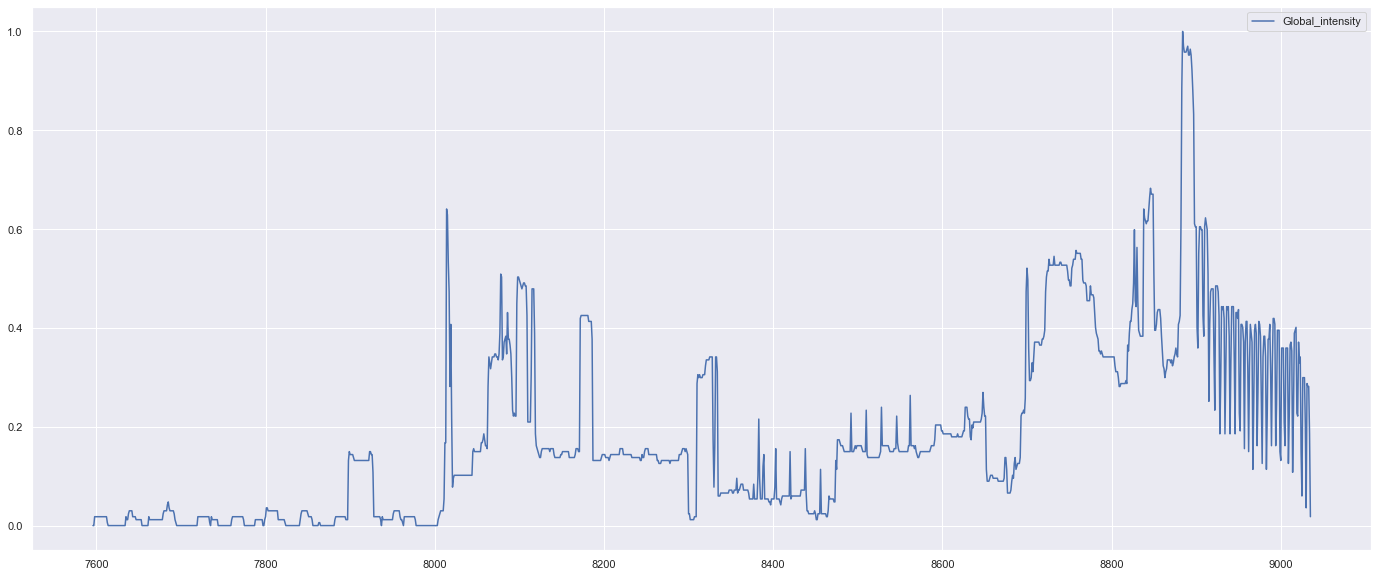

In [54]:
# plotting target variable
y.plot()

In [55]:
# regression model
regression_model = LinearRegression().fit(X_train, y_train)

In [56]:
# predicting using test data set
y_pred = regression_model.predict(X_test)

In [57]:
y_test = y_test.to_numpy()

In [58]:
# outputting some metrics
metrics.mean_absolute_error(y_test, y_pred)

0.0038412705045409836

In [59]:
metrics.mean_absolute_error(y_test, y_pred)

0.0038412705045409836

In [60]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

0.005745828776354604

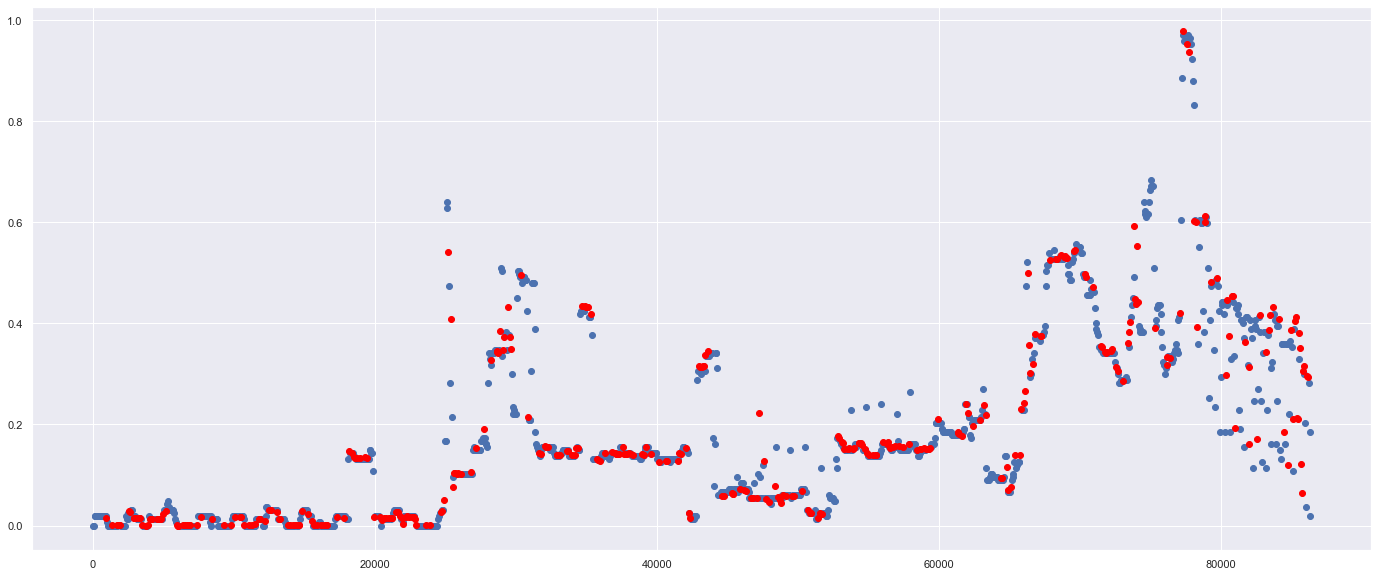

In [61]:
# plotting train vs test data
plt.scatter(X_train['Seconds'], y_train)
plt.scatter(X_test['Seconds'], y_pred, color='red')
plt.show();

In [62]:
# finding global maxima
np.argmax(y_pred)

236

In [63]:
y_pred[236]

array([0.97744627])

In [64]:
X_test_to_numpy = X_test.to_numpy()

In [65]:
X_test_to_numpy[[236]]

array([[1.00000000e+00, 2.18649518e-01, 9.00000000e-01, 0.00000000e+00,
        8.42105263e-01, 7.72800000e+04]])

In [66]:
X_9_to_11 = X_test.loc[(X_test['Seconds'] >= 77280) & (X_test['Seconds'] <= 81200)]

In [67]:
X_9_to_11

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds
8901,0.404842,0.128617,0.025,0.0,0.894737,78300
8925,0.498308,0.244373,0.000,0.0,0.000000,79740
8935,0.302525,0.102894,0.000,0.0,0.000000,80340
8910,0.617808,0.122186,0.000,0.0,0.894737,78840
8900,0.620672,0.000000,0.000,0.0,0.894737,78240
8939,0.382452,0.112540,0.000,0.0,0.000000,80580
8884,1.000000,0.218650,0.900,0.0,0.842105,77280
8891,0.958344,0.199357,0.900,0.0,0.894737,77700
8918,0.493361,0.000000,0.000,0.0,0.000000,79320
8946,0.194741,0.131833,0.000,0.0,0.000000,81000


In [68]:
twenty_after_spike = X_9_to_11.loc[(X_9_to_11['Seconds'] == 79320)]

In [69]:
# predicting with just one instance
twenty_after_spike_pred = regression_model.predict(twenty_after_spike)

In [70]:
twenty_after_spike_pred

array([[0.48177552]])

In [71]:
twenty_after_spike['Global_intensity'] = twenty_after_spike_pred

In [72]:
# data after spike
twenty_after_spike

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds,Global_intensity
8918,0.493361,0.0,0.0,0.0,0.0,79320,0.481776


In [73]:
df_friday_dec_22_predictions = X_test

In [74]:
df_friday_dec_22_predictions['Global_intensity'] = y_pred

In [75]:
df_friday_dec_22_predictions

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Seconds,Global_intensity
7764,0.014840,0.231511,0.000,0.0,0.000000,10080,0.017041
8201,0.149961,0.135048,0.000,0.0,0.894737,36300,0.143751
8144,0.148139,0.000000,0.025,0.0,0.894737,32880,0.140467
7661,0.000260,0.000000,0.000,0.0,0.000000,3900,0.000029
8224,0.147097,0.135048,0.000,1.0,0.947368,37680,0.141545
...,...,...,...,...,...,...,...
7696,0.000000,0.000000,0.000,0.0,0.000000,6000,-0.000153
7978,0.001562,0.000000,0.000,0.0,0.000000,22920,0.001931
8214,0.148139,0.147910,0.000,0.0,0.947368,37080,0.141894
8511,0.151263,0.000000,0.000,0.0,0.947368,54900,0.143842


In [76]:
# removing seconds to prepare for inverse normalization
df_friday_dec_22_predictions_seconds = df_friday_dec_22_predictions['Seconds']

In [77]:
df_friday_dec_22_predictions = df_friday_dec_22_predictions.drop(columns=['Seconds'])

In [78]:
df_friday_dec_22_predictions

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_intensity
7764,0.014840,0.231511,0.000,0.0,0.000000,0.017041
8201,0.149961,0.135048,0.000,0.0,0.894737,0.143751
8144,0.148139,0.000000,0.025,0.0,0.894737,0.140467
7661,0.000260,0.000000,0.000,0.0,0.000000,0.000029
8224,0.147097,0.135048,0.000,1.0,0.947368,0.141545
...,...,...,...,...,...,...
7696,0.000000,0.000000,0.000,0.0,0.000000,-0.000153
7978,0.001562,0.000000,0.000,0.0,0.000000,0.001931
8214,0.148139,0.147910,0.000,0.0,0.947368,0.141894
8511,0.151263,0.000000,0.000,0.0,0.947368,0.143842


In [79]:
# inversing normalization
df_friday_dec_22_predictions = scaler.inverse_transform(df_friday_dec_22_predictions)

In [80]:
# putting data back together
df_friday_dec_22_predictions = pd.DataFrame(df_friday_dec_22_predictions, 
                                  columns=['Global_active_power',
                                           'Global_reactive_power',
                                           'Sub_metering_1',
                                           'Sub_metering_2',
                                           'Sub_metering_3',
                                           'Global_intensity'])

In [81]:
df_friday_dec_22_predictions = df_friday_dec_22_predictions.assign(Seconds=df_friday_dec_22_predictions_seconds.values)

In [82]:
df_friday_dec_22_predictions

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_intensity,Seconds
0,0.316,0.144,0.800,0.0,0.000000,0.323772,10080
1,1.354,0.084,0.800,0.0,1.789474,2.731260,36300
2,1.340,0.000,1.635,0.0,1.789474,2.668866,32880
3,0.204,0.000,0.800,0.0,0.000000,0.000560,3900
4,1.332,0.084,0.800,40.0,1.894737,2.689360,37680
...,...,...,...,...,...,...,...
355,0.202,0.000,0.800,0.0,0.000000,-0.002914,6000
356,0.214,0.000,0.800,0.0,0.000000,0.036680,22920
357,1.340,0.092,0.800,0.0,1.894737,2.695982,37080
358,1.364,0.000,0.800,0.0,1.894737,2.733002,54900


In [83]:
df_friday_dec_22_predictions.loc[(df_friday_dec_22_predictions['Seconds']==79320)]

,Global_active_power,Global_reactive_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,Global_intensity,Seconds
246,3.992,0.0,0.8,0.0,0.0,9.153735,79320


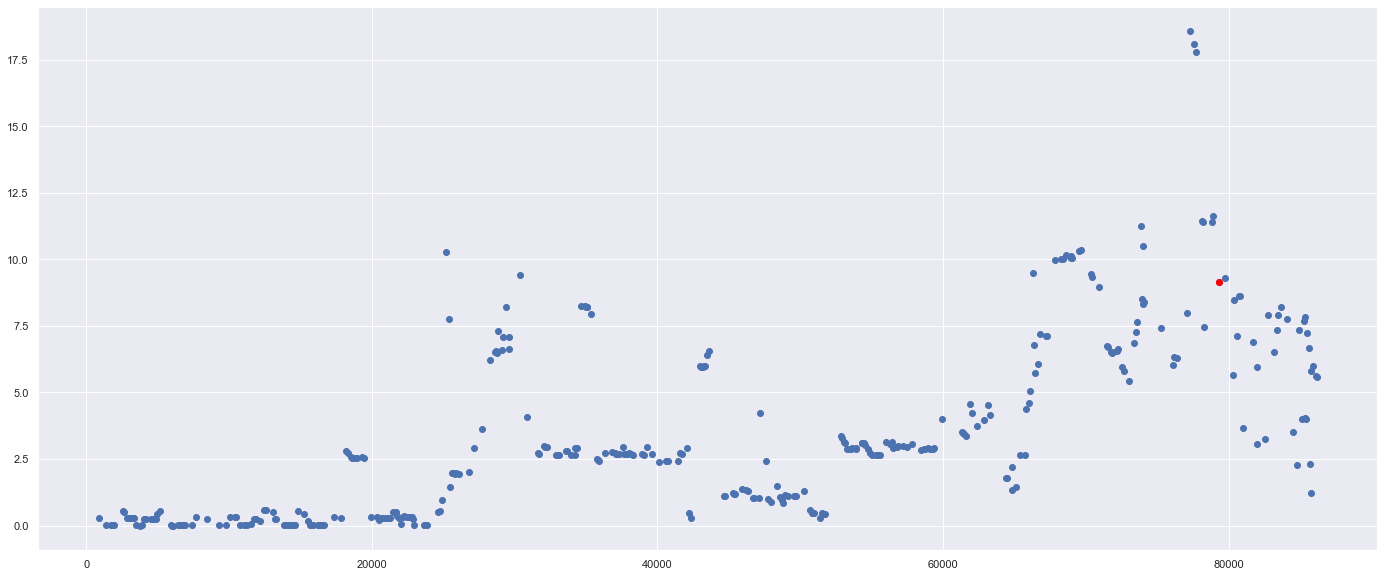

In [84]:
# plotting after inverse normalization
plt.scatter(df_friday_dec_22_predictions['Seconds'], df_friday_dec_22_predictions['Global_intensity'])
plt.scatter(79320, 9.153735, color='red')
plt.show();

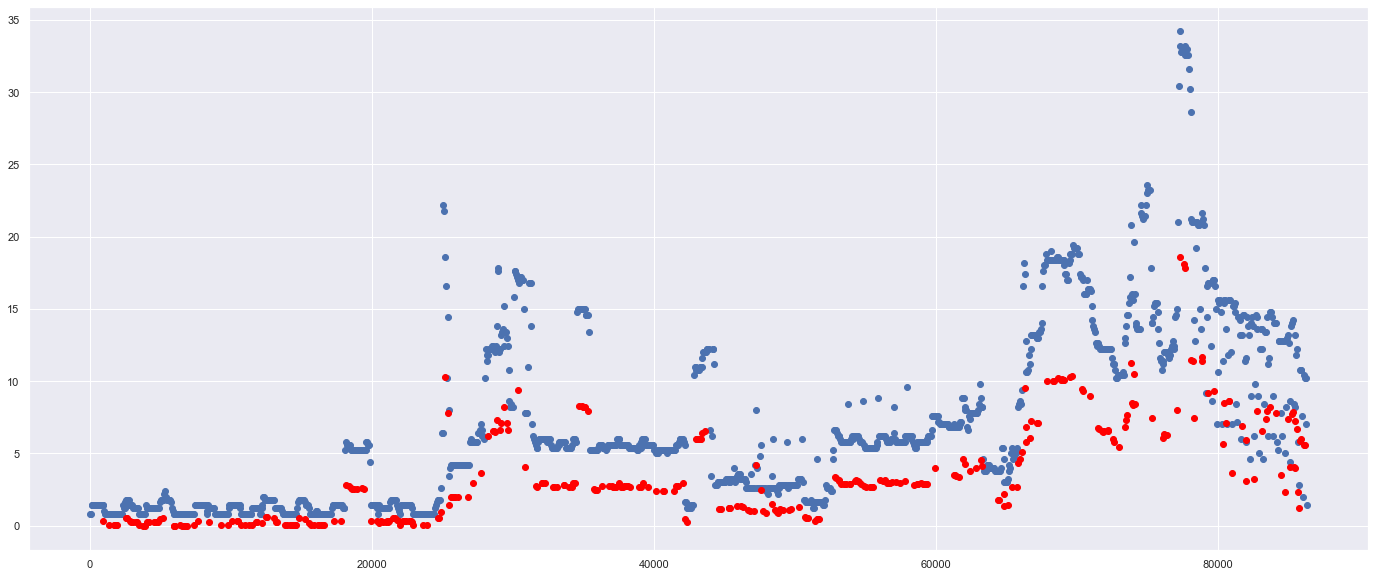

In [88]:
# finding trend of 20 minutes after rise
plt.scatter(friday_dec_22['Seconds'], friday_dec_22['Global_intensity'])
plt.scatter(df_friday_dec_22_predictions['Seconds'], df_friday_dec_22_predictions['Global_intensity'], color='red')
plt.show();

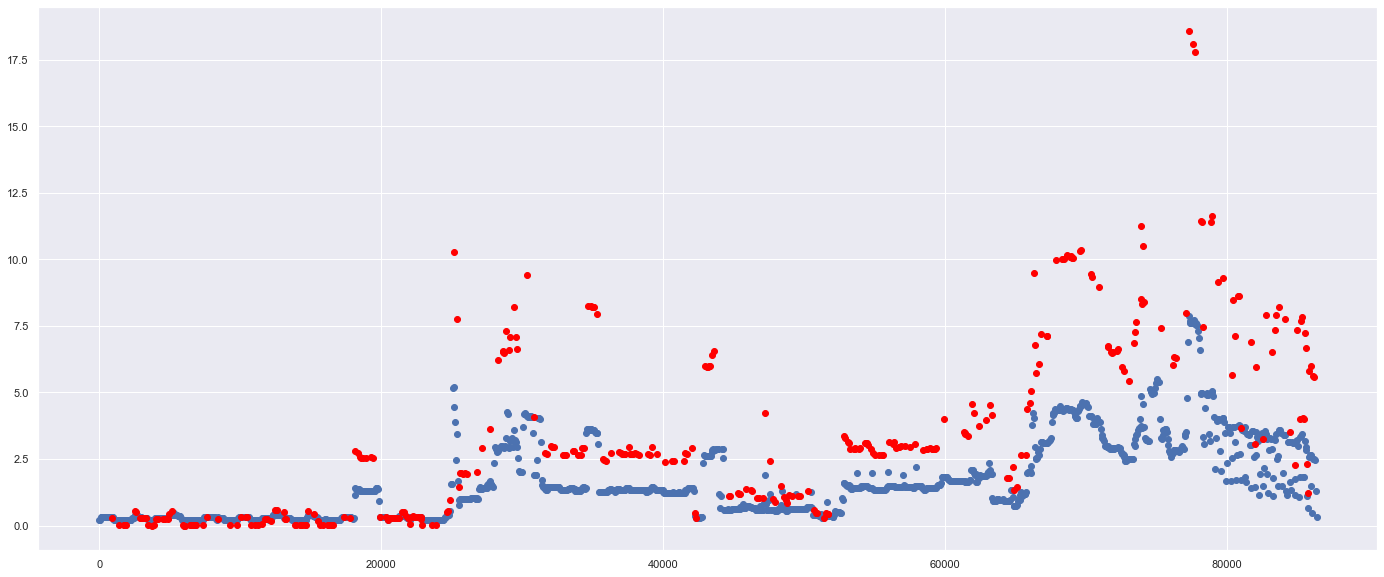

In [89]:
# finding global active power after rise in intensity
plt.scatter(friday_dec_22['Seconds'], friday_dec_22['Global_active_power'])
plt.scatter(df_friday_dec_22_predictions['Seconds'], df_friday_dec_22_predictions['Global_intensity'], color='red')
plt.show();